In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('seaborn-whitegrid')

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Model

from progressbar import ProgressBar

In [ ]:
def fn_divide(a, b): return np.divide(a+1e-6, b+1e-6)


def fn_standardize_df(df_tr_, df_ts_):

    from sklearn.preprocessing import StandardScaler
    df_tr, df_ts = df_tr_, df_ts_
    X_train, X_test = df_tr.iloc[:, :-1].values, df_ts.iloc[:, :-1].values

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test  = scaler.transform(X_test)

    df_tr = pd.DataFrame(X_train, columns = df_tr.columns[:-1]).assign(labels = df_tr.labels.values)
    df_ts = pd.DataFrame(X_test, columns  = df_ts.columns[:-1]).assign(labels = df_ts.labels.values)

    return df_tr, df_ts, scaler


def fn_acc(con_matrix):

    actual_total = con_matrix.sum(axis = 1)
    correct_preds = con_matrix.diagonal()
    acc = fn_divide(correct_preds.sum(), actual_total.sum())
    return np.round(100*acc, 3)



def fn_logloss(model_, X_, y_, labels = [0, 1]):

    y_pred = model_.predict(X_)
    bce = tf.keras.losses.BinaryCrossentropy()
    loss = bce(y_.reshape(-1, 1), y_pred.reshape(-1, 1)).numpy()
    return loss.item()



def fn_con_matrix_binary(model_, X_, y_, threshold_class_1 = 0.5):

    from sklearn.metrics import confusion_matrix

    proba_cls_1 = model_.predict(X_)

    y_pred = np.array([1 if i > threshold_class_1 else 0 for i in proba_cls_1])

    con_matrix = confusion_matrix(y_, y_pred)

    return con_matrix



def fn_prec_vec(con_matrix):

    pred_total = con_matrix.sum(axis = 0)
    correct_preds = con_matrix.diagonal()
    prec_vec = fn_divide(correct_preds, pred_total)

    return 100*prec_vec.round(3)



def fn_rec_vec(con_matrix):

    actual_total = con_matrix.sum(axis = 1)
    correct_preds = con_matrix.diagonal()
    rec_vec = fn_divide(correct_preds, actual_total)

    return 100*rec_vec.round(3)



def fn_model_perform_thresholds(model_, X_, y_, listO_thresh_cls_1, NN=False):

    from sklearn.metrics import confusion_matrix
    if NN == False:
        probas_both_cls = model_.predict_proba(X_)
        proba_cls_1 = probas_both_cls[:, 1]
    else:
        proba_cls_1 = model_.predict(X_)

    listO_metrics = []

    for thresh in listO_thresh_cls_1:
        y_pred = np.array([1 if i > thresh else 0 for i in proba_cls_1])
        con_matrix = confusion_matrix(y_, y_pred)
        prec_vec, rec_vec = fn_prec_vec(con_matrix), fn_rec_vec(con_matrix)
        listO_metrics.append([*prec_vec, *rec_vec, thresh])

    df_model_perform_thresholds = pd.DataFrame(np.array(listO_metrics))
    df_model_perform_thresholds.columns = ['prec_0', 'prec_1', 'rec_0', 'rec_1', 'thresh']

    return df_model_perform_thresholds





def fn_performance_models_data(listO_models, df_Xy_, legend, NN = False,
                               listO_thresh_cls_1 = np.linspace(0, 1, 10),
                               figsize=(15, 10)):

    X_test, y_test = df_Xy_.iloc[:, :-1].values, df_Xy_.iloc[:, -1].values

    plot_1, plot_2 = 'thresh rec_1', 'thresh prec_1'
    plot_3, plot_4 = 'thresh rec_0', 'thresh prec_0'

    listO_plot_titles = [plot_1, plot_2, plot_3, plot_4]
    subplot_grid = [2, 2]

    fig, axes = plt.subplots(*subplot_grid, figsize=figsize, sharey = False)
    axes = axes.ravel()
    for plot_n, title in enumerate(listO_plot_titles):
        x_axis, y_axis = title.split()

        for idx, model in enumerate(listO_models):

            df_model_perform_thresholds = fn_model_perform_thresholds(model, X_test, y_test,
                                                                      listO_thresh_cls_1 = listO_thresh_cls_1,
                                                                      NN = NN)
            df = df_model_perform_thresholds.sort_values(by = x_axis)
            axes[plot_n].plot(df[x_axis], df[y_axis], label = f'{legend[idx]}')
            title_1 = x_axis + ' - ' + y_axis
            axes[plot_n].set_xlabel(x_axis.upper())
            axes[plot_n].set_ylabel(y_axis.upper())
            axes[plot_n].set_title(title_1.upper())

        axes[plot_n].legend(prop={'size':12})

    plt.tight_layout()



def fn_test_model_binary_clf(df_Xy_, model_, threshold_class_1 = 0.5):

    df, model = df_Xy_, model_
    X, y = df.iloc[:, :-1].values, df.iloc[:, -1].values.ravel()

    con_matrix = fn_con_matrix_binary(model, X, y, threshold_class_1 = threshold_class_1)
    loss = fn_logloss(model, X, y)
    acc =  fn_acc(con_matrix)
    prec_vec = fn_prec_vec(con_matrix)
    rec_vec  = fn_rec_vec(con_matrix)

    df = pd.DataFrame().assign(prec = prec_vec, rec = rec_vec)
    df.index = ['class_' + str(i) for i in range(len(df))]
    print('--------------------')
    print(f'LOGLOSS : {round(loss, 4)}')
    print(f'ACCURACY: {round(acc, 3)}')
    print('--------------------')
    print()

    return df.round(3)

In [ ]:
def fn_NN_binary_clf(model, optimizer, df_tr, df_ts, model_save_path, batch_size=2048,
                     epochs=5, class_weight = {0:50, 1:50}):

    from tqdm.keras import TqdmCallback

    def fn_binary_metrics(df_history):

        df = df_history+1e-6
        TP, TN = df.TP.values, df.TN.values
        FP, FN = df.FP.values, df.FN.values
        rec_1,   rec_0 = TP/(TP+FN), TN/(TN+FP)
        prec_1, prec_0 = TP/(TP+FP), TN/(TN+FN)

        val_TP, val_TN = df.val_TP.values, df.val_TN.values
        val_FP, val_FN = df.val_FP.values, df.val_FN.values
        val_rec_1,   val_rec_0 = val_TP/(val_TP+val_FN), val_TN/(val_TN+val_FP)
        val_prec_1, val_prec_0 = val_TP/(val_TP+val_FP), val_TN/(val_TN+val_FN)

        diff_rec_1, diff_prec_1 = abs(rec_1 - val_rec_1), abs(prec_1 - val_prec_1)
        diff_rec_0, diff_prec_0 = abs(rec_0 - val_rec_0), abs(prec_0 - val_prec_0)

        return dict(tr_loss =  df.loss, ts_loss = df.val_loss,
                    tr_rec_1 = rec_1, tr_rec_0 = rec_0,
                    tr_prec_1 = prec_1, tr_prec_0 = prec_0,
                    diff_rec_1 = diff_rec_1, diff_prec_1 = diff_prec_1,
                    diff_rec_0 = diff_rec_0, diff_prec_0 = diff_prec_0)

    X_tr = df_tr.iloc[:, :-1].values
    X_ts = df_ts.iloc[:, :-1].values
    y_tr = df_tr.iloc[:, -1].values
    y_ts = df_ts.iloc[:, -1].values

    metrics =  [keras.metrics.TruePositives(name='TP'),
                keras.metrics.TrueNegatives(name='TN'),
                keras.metrics.FalsePositives(name='FP'),
                keras.metrics.FalseNegatives(name='FN')]

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=metrics)
    if model_save_path != None:
        call_back_1 = [keras.callbacks.ModelCheckpoint(model_save_path + model.name + '_epoch_{epoch}.h5')]
    call_back_2 = [TqdmCallback(verbose=0)]

    callbacks = call_back_2 if model_save_path == None else call_back_1 + call_back_2
    model_history = model.fit(X_tr, y_tr, validation_data=(X_ts, y_ts),
                                batch_size=batch_size,
                                    epochs=epochs,
                                 callbacks=callbacks,
                              class_weight=class_weight,
                                   verbose=0)

    df_history = pd.DataFrame(model_history.history)
    df_perform = pd.DataFrame().assign(**fn_binary_metrics(df_history))
    df_perform.index = [model.name + f'_epoch_{i}' for i in range(len(df_perform))]

    return df_perform, df_history

In [ ]:
def fn_embed_words_as_nums(corpus):
    dictO_word_embeds = {}
    pbar = ProgressBar()
    for sentence in pbar(corpus):
        for word in sentence.split():
            if word not in dictO_word_embeds:
                # Assign a unique index to each unique word:
                dictO_word_embeds[word] = (len(dictO_word_embeds) + 1)
                # Note that we don't attribute index 0 to anything.

    return dictO_word_embeds

In [ ]:
def fn_embed_docs(corpus, dictO_word_embeds, max_lg = 100):
    from keras.preprocessing.sequence import pad_sequences

    pbar = ProgressBar()
    listO_doc_vecs = []
    for doc in pbar(corpus):
        listO_words = doc.split()

        doc_vec = [dictO_word_embeds.get(word, 0) for word in listO_words]
        doc_vec = [num for num in doc_vec if num != 0][: max_lg]
        listO_doc_vecs.append(doc_vec)

    listO_padded_doc_vecs = pad_sequences(listO_doc_vecs)
    arryO_doc_vecs = np.array(listO_padded_doc_vecs)
    return arryO_doc_vecs

In [ ]:
data_path = 'gdrive/My Drive/3A_PGD/CODE_PGD/TRANSFORMERS/'

df_nlp_tr = pd.read_csv(data_path + 'df_nlp_tr.csv')
df_nlp_ts = pd.read_csv(data_path + 'df_nlp_ts.csv')

df_nlp_tr.sample(5)

,prod_id,reviews,ratings
138805,b007rtr8ts,i ve been using both the shampoo and condition...,1
108791,b007jfmh8m,good store bought cookie comes individually wr...,1
45380,b00016lzt8,this stuff is the real deal all right complete...,1
114982,b004867t24,i have to admit i was a little surprised by th...,1
52422,b001e5e10a,i have used sportea for years it is the best r...,1


In [ ]:
corpus = df_nlp_tr.reviews.values
dictO_word_embeds = fn_embed_words_as_nums(corpus)

100% (147659 of 147659) |################| Elapsed Time: 0:00:02 Time:  0:00:02


In [ ]:
vocab_size = len(dictO_word_embeds) + 1
vocab_size

65855

In [ ]:
tr_corpus = df_nlp_tr.reviews.values
ts_corpus = df_nlp_ts.reviews.values

tr_embeddings = fn_embed_docs(tr_corpus, dictO_word_embeds, max_lg = 100)
ts_embeddings = fn_embed_docs(ts_corpus, dictO_word_embeds, max_lg = 100)

tr_embeddings.shape, ts_embeddings.shape

100% (147659 of 147659) |################| Elapsed Time: 0:00:04 Time:  0:00:04
100% (36915 of 36915) |##################| Elapsed Time: 0:00:01 Time:  0:00:01


((147659, 100), (36915, 100))

In [ ]:
tr_embeddings

array([[   1,    2,    3, ...,   69,   70,   71],
       [  45,   47,   83, ...,   45,  136,   26],
       [ 176,   72,   10, ...,  246,   10,  247],
       ...,
       [   0,    0,    0, ...,  161,   20, 1060],
       [   0,    0,    0, ...,  548,   26,  151],
       [  52, 1504,   47, ...,   52, 2945, 2211]], dtype=int32)

In [ ]:
y_tr = df_nlp_tr.ratings.values
y_ts = df_nlp_ts.ratings.values

y_tr.shape, y_ts.shape

((147659,), (36915,))

In [ ]:
df_tr = pd.DataFrame(tr_embeddings).assign(labels = y_tr)
df_ts = pd.DataFrame(ts_embeddings).assign(labels = y_ts)

df_tr.shape, df_ts.shape

((147659, 101), (36915, 101))

In [ ]:
def fn_TRANSFORMER_BLOCK(vocab_size = vocab_size, max_sentence_lg = 100,
                         embed_dim = 32, num_heads = 5, ff_dim = 32):

    input = layers.Input(shape = (max_sentence_lg,))
    positions = np.array(range(max_sentence_lg))

    pos_emb = layers.Embedding(input_dim=max_sentence_lg, output_dim=embed_dim)(positions)
    word_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(input)
    emb = word_emb + pos_emb

    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(emb, emb)
    attn_output = layers.Dropout(0.3)(attn_output)
    out = layers.LayerNormalization()(emb + attn_output)
    x = layers.Dense(ff_dim, activation="relu")(out)
    x = layers.Dense(embed_dim)(x)
    x = layers.Dropout(0.1)(x)
    output = layers.LayerNormalization()(out + x)

    output = layers.GlobalAveragePooling1D()(output)
    output = layers.Dropout(0.1)(output)
    output = layers.Dense(20, activation="relu")(output)
    output = layers.Dropout(0.1)(output)
    output = layers.Dense(20, activation="relu")(output)
    output = layers.Dropout(0.1)(output)
    output = layers.Dense(1, activation="sigmoid")(output)

    model = Model(input, output)
    return model



In [ ]:
transformer = fn_TRANSFORMER_BLOCK()
transformer.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 100, 32)      2107360     input_3[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add_6 (TFOpLam (None, 100, 32)      0           embedding_5[0][0]                
__________________________________________________________________________________________________
multi_head_attention_2 (MultiHe (None, 100, 32)      20992       tf.__operators__.add_6[0][0]     
                                                                 tf.__operators__.add_6[0][0

In [ ]:
model = transformer
optimizer=tf.keras.optimizers.Adamax()

df_tr_, df_ts_ = df_tr, df_ts
model_save_path =  data_path + 'TRANSFORMER_MODELS/model_A/'

batch_size, epochs = 250, 15
class_bias = {0:85, 1:15}

z = fn_NN_binary_clf(model, optimizer, df_tr_, df_ts_, model_save_path,
                     batch_size=batch_size, epochs=epochs,
                     class_weight = class_bias)

df_performance_model_2, df_history_2 = z

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.



In [ ]:
regd_columns = 'tr_prec_1 tr_rec_1 tr_prec_0 tr_rec_0 diff_rec_1 diff_rec_0'.split()
df_performance_model_2.loc[:, regd_columns].describe()

,tr_prec_1,tr_rec_1,tr_prec_0,tr_rec_0,diff_rec_1,diff_rec_0
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.969475,0.833751,0.455348,0.840762,0.003285,0.009922
std,0.012229,0.023705,0.049354,0.059821,0.005427,0.024081
min,0.929934,0.765665,0.311234,0.647328,0.000668,0.000298
25%,0.969358,0.827495,0.443905,0.840364,0.001124,0.001068
50%,0.973872,0.840561,0.469918,0.862403,0.001261,0.001886
75%,0.976075,0.848984,0.486567,0.873050,0.002323,0.004851
max,0.977284,0.856712,0.501311,0.878544,0.021829,0.094638


In [ ]:
dff = df_performance_model_2
df1 = dff[dff.diff_rec_0 < 0.03]
df2 = df1[df1.diff_rec_1 < 0.03]
df3 = df2[df2.tr_rec_0 > 0.85]
df_filtered_2 = df3[df3.tr_rec_1 > 0.85]
df_filtered_2.loc[:, regd_columns]

,tr_prec_1,tr_rec_1,tr_prec_0,tr_rec_0,diff_rec_1,diff_rec_0
model_2_epoch_12,0.976712,0.852202,0.492882,0.876075,0.001005,0.000754
model_2_epoch_13,0.977072,0.854299,0.496864,0.877712,0.001163,0.000298
model_2_epoch_14,0.977284,0.856712,0.501311,0.878544,0.000668,0.000843


In [ ]:
def fn_load(model_name, model_save_path = model_save_path):
    model_name = model_save_path + model_name + '.h5'
    return keras.models.load_model(model_name)

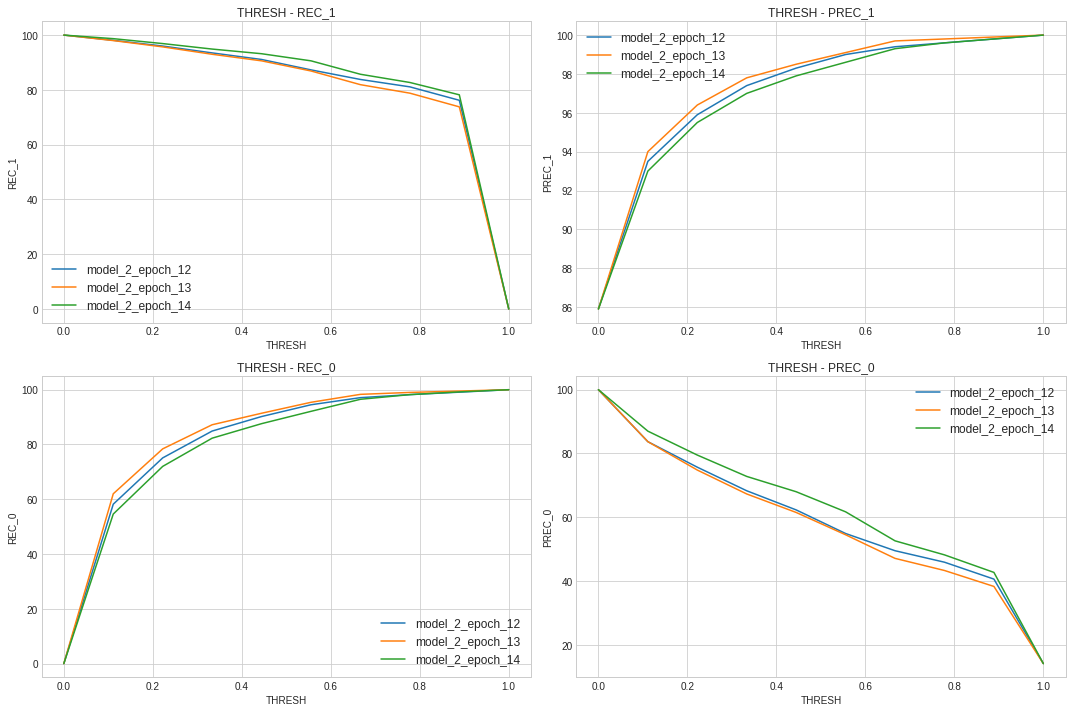

In [ ]:
kwargs = dict(model_save_path = data_path + 'TRANSFORMER_MODELS/model_A/')
listO_filtered_models_2 = [fn_load(i, **kwargs) for i in list(df_filtered_2.index)]
df_Xy_ = df_tr
legend = list(df_filtered_2.index)

fn_performance_models_data(listO_filtered_models_2, df_Xy_, legend, NN=True)

In [ ]:
df_Xy_ = df_tr_

model_ =  listO_filtered_models_2[-1]
thresh = 0.65

fn_test_model_binary_clf(df_Xy_, model_, threshold_class_1 = thresh)

--------------------
LOGLOSS : 0.1903
ACCURACY: 87.68
--------------------



,prec,rec
class_0,53.5,96.2
class_1,99.3,86.3


In [ ]:
df_Xy_ = df_ts_

fn_test_model_binary_clf(df_Xy_, model_, threshold_class_1 = thresh)

--------------------
LOGLOSS : 0.2946
ACCURACY: 84.053
--------------------



,prec,rec
class_0,46.3,82.9
class_1,96.8,84.2


In [ ]:
tf.keras.layers.MultiHeadAttention(
    num_heads,
    key_dim,
    value_dim=None,
    kernel_initializer="glorot_uniform")